by inês <3 doing my best

In [46]:
import pandas as pd
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import ast
import re

# 1. XGBoost

In [2]:
df = pd.read_pickle("../../extra_features.pkl")
df_example = df.xs("IPG", level='Ticker', axis=1)

In [14]:
df_example

Price                      Close_Ratio_2       Trend_2  Close_Ratio_5  \
Date                                                                    
2010-12-31 00:00:00+00:00       0.999529  9.418919e-04       0.998496   
2011-01-03 00:00:00+00:00       1.006548  8.863256e-07       1.010329   
2011-01-04 00:00:00+00:00       0.986340  1.224159e-02       0.985876   
2011-01-05 00:00:00+00:00       1.007112 -1.376885e-02       1.000000   
2011-01-06 00:00:00+00:00       0.999529 -1.262496e-02       0.999435   
...                                  ...           ...            ...   
2024-01-24 00:00:00+00:00       0.999225  1.345748e-02       1.005679   
2024-01-25 00:00:00+00:00       1.010591  3.745334e-03       1.019890   
2024-01-26 00:00:00+00:00       1.000910  1.985978e-02       1.014644   
2024-01-29 00:00:00+00:00       1.006327  2.323131e-02       1.019474   
2024-01-30 00:00:00+00:00       0.998050  1.455763e-02       1.009405   

Price                       Trend_5  Close_Ratio_60  Trend_60  \
Date                                                            
2010-12-31 00:00:00+00:00 -0.013967        0.997589  0.020012   
2011-01-03 00:00:00+00:00 -0.013053        1.009933  0.041950   
2011-01-04 00:00:00+00:00  0.006635        0.982714  0.055133   
2011-01-05 00:00:00+00:00 -0.013768        0.996933  0.006717   
2011-01-06 00:00:00+00:00  0.000559        0.996057 -0.001879   
...                             ...             ...       ...   
2024-01-24 00:00:00+00:00  0.014827        1.039036  0.169285   
2024-01-25 00:00:00+00:00  0.024281        1.058075  0.163041   
2024-01-26 00:00:00+00:00  0.035835        1.057001  0.193796   
2024-01-29 00:00:00+00:00  0.035140        1.067447  0.181105   
2024-01-30 00:00:00+00:00  0.039712        1.060351  0.178103   

Price                      Close_Ratio_250  Trend_250        EMA        RSI  \
Date                                                                          
2010-12-31 00:00:00+00:00         1.201651   0.424971   6.928688  29.347987   
2011-01-03 00:00:00+00:00         1.215671   0.434654   6.932073  42.708313   
2011-01-04 00:00:00+00:00         1.181193   0.447837   6.906118  30.578641   
2011-01-05 00:00:00+00:00         1.196307   0.446389   6.899062  41.599986   
2011-01-06 00:00:00+00:00         1.193492   0.459338   6.892098  46.428661   
...                                    ...        ...        ...        ...   
2024-01-24 00:00:00+00:00         0.964414  -0.046268  31.174617  46.938804   
2024-01-25 00:00:00+00:00         0.985270  -0.043157  31.286949  45.345371   
2024-01-26 00:00:00+00:00         0.987247  -0.012660  31.390945  51.140184   
2024-01-29 00:00:00+00:00         0.999971  -0.005557  31.541565  62.974681   
2024-01-30 00:00:00+00:00         0.996304   0.002708  31.649628  61.993728   

Price                        Target  
Date                                 
2010-12-31 00:00:00+00:00 -0.000941  
2011-01-03 00:00:00+00:00  0.013183  
2011-01-04 00:00:00+00:00 -0.026951  
2011-01-05 00:00:00+00:00  0.014326  
2011-01-06 00:00:00+00:00 -0.000941  
...                             ...  
2024-01-24 00:00:00+00:00 -0.001549  
2024-01-25 00:00:00+00:00  0.021409  
2024-01-26 00:00:00+00:00  0.001823  
2024-01-29 00:00:00+00:00  0.012735  
2024-01-30 00:00:00+00:00 -0.003892  

[3291 rows x 11 columns]

In [3]:
y = df.xs("Target", level='Price', axis=1).shift(-1).dropna()
X = df.iloc[:-1]

In [16]:
tickers_to_keep = ["AAPL", "MSFT"]  # Specify the two tickers you want to keep

# Filter the DataFrame for the specified tickers
filtered_df = df.loc[:, df.columns.get_level_values("Ticker").isin(tickers_to_keep)]
filtered_df

Ticker                             AAPL                                    \
Price                     Close_Ratio_2   Trend_2 Close_Ratio_5   Trend_5   
Date                                                                        
2010-12-31 00:00:00+00:00      0.998298 -0.005563      0.994537 -0.004591   
2011-01-03 00:00:00+00:00      1.010749 -0.008409      1.013095 -0.003192   
2011-01-04 00:00:00+00:00      1.002603  0.018333      1.014751  0.015203   
2011-01-05 00:00:00+00:00      1.004074  0.026951      1.017623  0.017989   
2011-01-06 00:00:00+00:00      0.999596  0.013399      1.010599  0.026722   
...                                 ...       ...           ...       ...   
2024-01-24 00:00:00+00:00      0.998255  0.018816      1.009069  0.061747   
2024-01-25 00:00:00+00:00      0.999151  0.003169      1.001599  0.063436   
2024-01-26 00:00:00+00:00      0.995473 -0.005181      0.991692  0.029169   
2024-01-29 00:00:00+00:00      0.998204 -0.010710      0.990341  0.004623   
2024-01-30 00:00:00+00:00      0.990284 -0.012599      0.978498 -0.011126   

Ticker                                                                        \
Price                     Close_Ratio_60  Trend_60 Close_Ratio_250 Trend_250   
Date                                                                           
2010-12-31 00:00:00+00:00       1.029646  0.117604        1.239626  0.449450   
2011-01-03 00:00:00+00:00       1.049768  0.113340        1.264260  0.444322   
2011-01-04 00:00:00+00:00       1.053166  0.134969        1.268509  0.481960   
2011-01-05 00:00:00+00:00       1.059612  0.123418        1.276500  0.489028   
2011-01-06 00:00:00+00:00       1.056789  0.127212        1.273062  0.490560   
...                                  ...       ...             ...       ...   
2024-01-24 00:00:00+00:00       1.033837  0.137288        1.107752  0.340182   
2024-01-25 00:00:00+00:00       1.029695  0.158410        1.104589  0.341399   
2024-01-26 00:00:00+00:00       1.018403  0.148744        1.093456  0.324899   
2024-01-29 00:00:00+00:00       1.012858  0.127425        1.088310  0.302202   
2024-01-30 00:00:00+00:00       0.992116  0.121021        1.066286  0.318694   

Ticker                                            ...          MSFT            \
Price                             EMA        RSI  ... Close_Ratio_5   Trend_5   
Date                                              ...                           
2010-12-31 00:00:00+00:00    9.730903  59.087718  ...      0.998141 -0.012081   
2011-01-03 00:00:00+00:00    9.761356  73.700880  ...      1.001288 -0.013828   
2011-01-04 00:00:00+00:00    9.795096  74.778202  ...      1.004649 -0.003193   
2011-01-05 00:00:00+00:00    9.836206  79.982761  ...      1.001216  0.002876   
2011-01-06 00:00:00+00:00    9.869740  77.428973  ...      1.023437  0.001099   
...                               ...        ...  ...           ...       ...   
2024-01-24 00:00:00+00:00  189.110498  78.706971  ...      1.011198  0.022044   
2024-01-25 00:00:00+00:00  189.743250  72.480451  ...      1.011411  0.033269   
2024-01-26 00:00:00+00:00  190.010735  67.773408  ...      1.006418  0.027710   
2024-01-29 00:00:00+00:00  190.131436  63.767439  ...      1.014168  0.013201   
2024-01-30 00:00:00+00:00  189.668640  55.277850  ...      1.006543  0.032954   

Ticker                                                                        \
Price                     Close_Ratio_60  Trend_60 Close_Ratio_250 Trend_250   
Date                                                                           
2010-12-31 00:00:00+00:00       1.057484  0.144330        1.044120 -0.060995   
2011-01-03 00:00:00+00:00       1.057732  0.143199        1.047077 -0.059164   
2011-01-04 00:00:00+00:00       1.059440  0.141613        1.051467 -0.050519   
2011-01-05 00:00:00+00:00       1.053688  0.143914        1.048417 -0.036188   
2011-01-06 00:00:00+00:00       1.081736  0.139896        1.079256 -0.046289   
...                      

In [19]:
y = filtered_df.xs("Target", level='Price', axis=1).shift(-1).dropna()
X = filtered_df.iloc[:-1]

When determining the optimal training size for time series forecasting, a key consideration is the balance between the amount of historical data and the ability of the model to generalize effectively. Commonly, a "window size" is chosen, which refers to the number of past observations used to train a model before predicting future points. Research suggests that for time series data, particularly in volatile and unpredictable contexts, using a larger window (e.g., 70% of the data) can improve model performance as it captures enough historical context, but care must be taken to avoid overfitting to past patterns. For example, one approach using a sliding window technique with a 70% training size has been applied successfully, where data is divided into a training set and a test set based on this proportion.

Furthermore, some studies suggest that using cross-validation methods like Time Series Split or Sliding Window cross-validation can provide better insights into model performance across different segments of the data. These methods test the model on multiple, time-sensitive segments and can help determine whether increasing the training size (or adjusting the window) consistently leads to improved predictions.

In terms of practical implementation, experimenting with different window sizes (e.g., 60%, 70%, 80%) and horizons (e.g., predicting 5-day or 10-day ahead) is advised. Testing this across multiple time periods can also help ensure robustness, especially for volatile financial markets or stock prices.

In [4]:
def time_series_cv(X, y, train_size=0.7, horizon=5):
    n = len(y)
    train_len = int(n * train_size)
    
    results = []

    # Iterate through the dataset to create folds
    for start_idx in range(0, n - train_len - horizon + 1, horizon):
        train_end_idx = start_idx + train_len
        test_start_idx = train_end_idx
        test_end_idx = test_start_idx + horizon

        # Split X and y into training and testing sets
        train_X = X.iloc[start_idx:train_end_idx]
        train_y = y.iloc[start_idx:train_end_idx]
        test_X = X.iloc[test_start_idx:test_end_idx]
        test_y = y.iloc[test_start_idx:test_end_idx]

        # Retrieve start and end dates from the index
        train_start_date = train_X.index[0]
        train_end_date = train_X.index[-1]
        test_start_date = test_X.index[0]
        test_end_date = test_X.index[-1]

        print(f"  Training: {train_start_date} to {train_end_date}")
        print(f"  Testing: {test_start_date} to {test_end_date}")


        # Fit model
        model = XGBRegressor()
        model.fit(train_X, train_y)
        
        # Predict and evaluate performance
        predictions = model.predict(test_X)
        error = mean_squared_error(test_y, predictions)
        print(f"  Error: {error:.4f}")
        
        results.append(error)
    
    return np.mean(results), np.std(results)

1. **Total number of rows**: 3291 rows (representing data from 2011 to 2024).
2. **Training set size**: 70% of the total data. 
   - Training size = 0.70×3291 = 2303.7 ≈ 2304 rows.
3. **Testing set size**: 5 rows for each test (since we want to predict 5 days ahead).
   - Remaining data (for testing):  3291 - 2304 = 987 rows.
   - Number of sets: $$ \text{Number of test sets} = \frac{987}{5} = 197.4 \approx 197 $$ sets.

Final Calculation:
- **Training set**: 2304 rows (70% of data).
- **Test sets**: 197 sets, each containing 5 days of predictions.


In [ ]:
mean, std = time_series_cv(X,y)

this took to much time, so we're doing it by ticker for a second experiment

In [17]:
def time_series_cv_2(X, y, ticker, train_size=0.9, horizon=5):
    n = len(y)
    train_len = int(n * train_size)
    
    results = []

    # Iterate through the dataset to create folds
    for start_idx in range(0, n - train_len - horizon + 1, horizon):
        train_end_idx = start_idx + train_len
        test_start_idx = train_end_idx
        test_end_idx = test_start_idx + horizon

        # Split X and y into training and testing sets
        train_X = X.iloc[start_idx:train_end_idx]
        train_y = y.iloc[start_idx:train_end_idx]
        test_X = X.iloc[test_start_idx:test_end_idx]
        test_y = y.iloc[test_start_idx:test_end_idx]

        # Retrieve start and end dates from the index
        train_start_date = train_X.index[0]
        train_end_date = train_X.index[-1]
        test_start_date = test_X.index[0]
        test_end_date = test_X.index[-1]

        print(f"  Training: {train_start_date} to {train_end_date}")
        print(f"  Testing: {test_start_date} to {test_end_date}")


        # Fit model
        model = XGBRegressor()
        model.fit(train_X, train_y)
        
        # Predict and evaluate performance
        predictions = model.predict(test_X)
        error = mean_squared_error(test_y, predictions)
        r2 = r2_score(test_y, predictions)
        print(f"  Error: {error:.4f}")

        # Save fold results
        results.append({
            "train_start_date": train_start_date,
            "train_end_date": train_end_date,
            "test_start_date": test_start_date,
            "test_end_date": test_end_date,
            "mse": error,
            "r2_score": r2
        })

    # Calculate mean target value and overall error statistics
    mean_error = np.mean([r["mse"] for r in results])
    std_error = np.std([r["mse"] for r in results])
    mean_r2 = np.mean([r["r2_score"] for r in results])
    std_r2 = np.std([r["r2_score"] for r in results])

    # Feature importance from XGBoost
    feature_importances = model.feature_importances_

    # Summary results
    summary = {
        "ticker": ticker,
        "mean_error": mean_error,
        "std_error": std_error,
        "feature_importances": feature_importances,
        "mean_r2": mean_r2,
        "std_r2": std_r2
    }
        
    
    return summary

In [18]:
tickers = df.columns.get_level_values("Ticker").unique()
tickers

Index(['HAL', 'K', 'IRM', 'HES', 'KEY', 'DGX', 'TER', 'YUM', 'GRMN', 'ARE',
       ...
       'IPG', 'CMI', 'EA', 'MSCI', 'SCHW', 'DLR', 'DD', 'SWK', 'MSFT', 'ROK'],
      dtype='object', name='Ticker', length=392)

In [19]:
results = []

In [20]:
for ticker in tickers:
    df_example = df.xs(str(ticker), level='Ticker', axis=1)
    X = df_example.iloc[:-1]
    y = df_example['Target'].shift(-1).dropna()
    #print(y)
    results.append(time_series_cv_2(X,y,ticker))

  Training: 2010-12-31 00:00:00+00:00 to 2022-10-05 00:00:00+00:00
  Testing: 2022-10-06 00:00:00+00:00 to 2022-10-12 00:00:00+00:00
  Error: 0.0016
  Training: 2011-01-07 00:00:00+00:00 to 2022-10-12 00:00:00+00:00
  Testing: 2022-10-13 00:00:00+00:00 to 2022-10-19 00:00:00+00:00
  Error: 0.0011
  Training: 2011-01-14 00:00:00+00:00 to 2022-10-19 00:00:00+00:00
  Testing: 2022-10-20 00:00:00+00:00 to 2022-10-26 00:00:00+00:00
  Error: 0.0014
  Training: 2011-01-24 00:00:00+00:00 to 2022-10-26 00:00:00+00:00
  Testing: 2022-10-27 00:00:00+00:00 to 2022-11-02 00:00:00+00:00
  Error: 0.0004
  Training: 2011-01-31 00:00:00+00:00 to 2022-11-02 00:00:00+00:00
  Testing: 2022-11-03 00:00:00+00:00 to 2022-11-09 00:00:00+00:00
  Error: 0.0012
  Training: 2011-02-07 00:00:00+00:00 to 2022-11-09 00:00:00+00:00
  Testing: 2022-11-10 00:00:00+00:00 to 2022-11-16 00:00:00+00:00
  Error: 0.0006
  Training: 2011-02-14 00:00:00+00:00 to 2022-11-16 00:00:00+00:00
  Testing: 2022-11-17 00:00:00+00:00 to

In [21]:
# Convert results to a DataFrame
results_df = pd.DataFrame(results)

# Save to CSV
results_df.to_csv("../results_xgboost.csv", index=False)

print("Results saved to 'results_xgboost.csv'")

Results saved to 'results_xgboost.csv'


In [22]:
df_results = pd.read_csv("../results_xgboost.csv")
df_results

ticker  mean_error  ...   mean_r2     std_r2
0      HAL    0.000716  ... -0.956805   1.272772
1        K    0.000220  ... -2.339924   4.808908
2      IRM    0.000345  ... -3.044726  12.232281
3      HES    0.000601  ... -1.483524   2.041556
4      KEY    0.001351  ... -1.017389   1.836155
..     ...         ...  ...       ...        ...
387    DLR    0.000574  ... -0.964014   1.632341
388     DD    0.000347  ... -0.987768   1.464419
389    SWK    0.000732  ... -1.823586   4.609761
390   MSFT    0.000387  ... -0.750132   1.074789
391    ROK    0.000394  ... -0.906223   1.188479

[392 rows x 6 columns]

---

Lower MSE

In [ ]:
min_mse_index = df_results['mean_error'].idxmin()
best_result = df_results.loc[min_mse_index]
best_result

ticker                                                                KO
mean_error                                                      0.000121
std_error                                                       0.000158
feature_importances    [0.07101501 0.0749062  0.08472033 0.11272638 0...
mean_r2                                                         -1.64208
std_r2                                                          2.983085
Name: 319, dtype: object

In [45]:
best_result['feature_importances']

'[0.07101501 0.0749062  0.08472033 0.11272638 0.11314011 0.10034785\n 0.11695144 0.10873876 0.11592582 0.10152811 0.        ]'

In [58]:
feature_importances_str = best_result['feature_importances']

# Replace multiple spaces with a single space
cleaned_str = re.sub(r"\s+", " ", feature_importances_str)

# Replace spaces between numbers with commas
corrected_str = cleaned_str.replace(" ", ", ")

# Use ast.literal_eval to convert it into a Python list
feature_importances = ast.literal_eval(corrected_str)

print("Feature Importances:", feature_importances)

Feature Importances: [0.07101501, 0.0749062, 0.08472033, 0.11272638, 0.11314011, 0.10034785, 0.11695144, 0.10873876, 0.11592582, 0.10152811, 0.0]


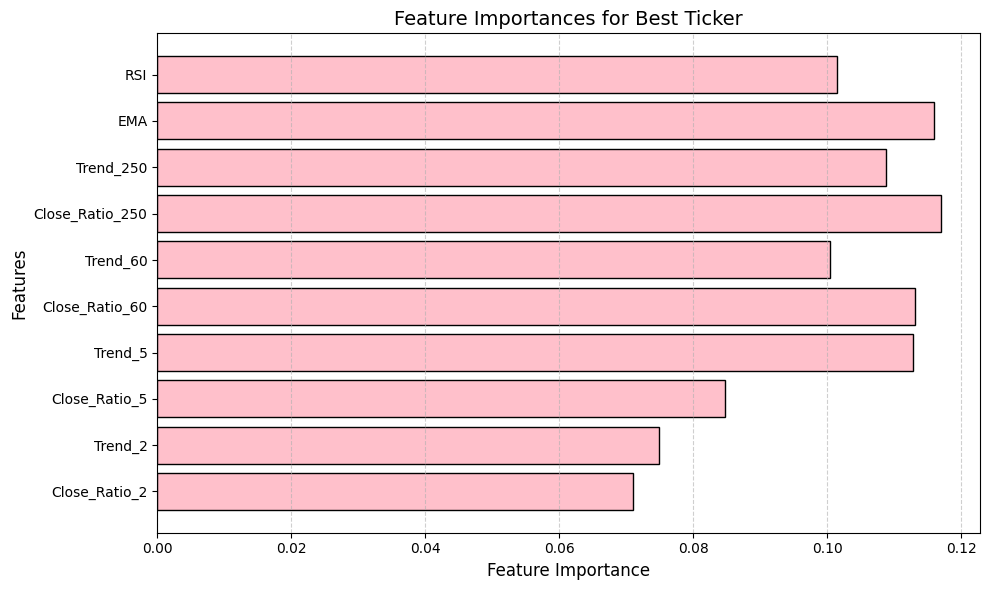

In [59]:
import matplotlib.pyplot as plt
import numpy as np

# Example feature names
feature_names = ['Close_Ratio_2', 'Trend_2', 'Close_Ratio_5', 'Trend_5',
                 'Close_Ratio_60', 'Trend_60', 'Close_Ratio_250', 'Trend_250', 
                 'EMA', 'RSI']

# Example feature importances from your best result
feature_importances = feature_importances[:-1]

# Create a barplot
plt.figure(figsize=(10, 6))
plt.barh(feature_names, feature_importances, color='pink', edgecolor='black')
plt.xlabel('Feature Importance', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.title('Feature Importances for Best Ticker', fontsize=14)
plt.grid(axis='x', linestyle='--', alpha=0.6)

# Display the plot
plt.tight_layout()
plt.show()


### Visualizing the Results

Mean Error and Mean R²

In [24]:
# Bar plot for mean_error and mean_r2
results_melted = results.melt(id_vars="ticker", value_vars=["mean_error", "mean_r2"], 
                              var_name="Metric", value_name="Value")

plt.figure(figsize=(10, 6))
sns.barplot(data=results_melted, x="ticker", y="Value", hue="Metric")
plt.title("Mean Error and R² by Ticker")
plt.ylabel("Value")
plt.show()

AttributeError: 'list' object has no attribute 'melt'

In [ ]:
plt.figure(figsize=(10, 6))
plt.bar(results["ticker"], results["mean_error"], yerr=results["std_error"], label="Mean Error", alpha=0.7)
plt.bar(results["ticker"], results["mean_r2"], yerr=results["std_r2"], label="Mean R²", alpha=0.7)
plt.legend()
plt.title("Mean Error and R² with Variability")
plt.show()

In [ ]:
# Hyperparameter tuning using grid search

from sklearn.model_selection import GridSearchCV

param_grid = {

    'learning_rate': [0.01, 0.1, 0.2],

    'max_depth': [3, 5, 7],

    'subsample': [0.8, 0.9, 1.0]

}

grid_search = GridSearchCV(XGBRegressor(), param_grid, cv=3)

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_

---

- Chang, V., Xu, Q.A., Chidozie, A. and Wang, H. (2024). Predicting Economic Trends and Stock Market Prices with Deep Learning and Advanced Machine Learning Techniques. Electronics, [online] 13(17), p.3396. doi:https://doi.org/10.3390/electronics13173396.

- Github.io. (2022). Time Series Cross Validation — forecast-tools. [online] Available at: https://tommonks.github.io/forecast-tools/content/03_cross_validation.html [Accessed 5 Dec. 2024].

- Sharma, N. (2024). How to Use XGBoost for Time-Series Forecasting? [online] Analytics Vidhya. Available at: https://www.analyticsvidhya.com/blog/2024/01/xgboost-for-time-series-forecasting/.